In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import scipy.interpolate as interp

In [3]:
data = np.load('01042025/data_raw_20v_FP133-20250401_x2.npy') * 1000 # convert to mV
hydrophone_sensitivity_raw = np.loadtxt('Hydrophone_sensitivity/PAFOH27 + FP133-02T Sensitivity 09January25.txt'
                                        , skiprows=81)
hydrophone_sensitivity_raw[:, 0] = hydrophone_sensitivity_raw[:, 0] * 1e6 # convert to Mhz

In [4]:
num_of_samples = 100
steps_per_sample = 250

steps_per_mm = 200
sampling_rate = 1/100e6

slice = (68, 0, 0)

data.shape

(100, 1, 5, 10000)

In [5]:
# convert to Pressure: 
data_raw_fft = np.zeros(data.shape)
data_pressure_fft = np.zeros(data.shape)
data_pressure = np.zeros(data.shape)

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        for k in range(data.shape[2]):
            data_fft = np.fft.fft(data[i][j][k][:])
            freq = (np.fft.fftfreq(len(data[i][j][k][:]), sampling_rate)) # sampling rate
            freq = freq /(2*np.pi) #convert from rad/s to Hz
            hydrophone_sensitivity= np.interp(freq
                                            ,hydrophone_sensitivity_raw[:, 0]
                                            ,hydrophone_sensitivity_raw[:, 1])
            out_fft = data_fft/hydrophone_sensitivity
            out = np.fft.ifft(out_fft)
            
            data_raw_fft[i][j][k] = np.real(data_fft)
            data_pressure_fft[i][j][k] = np.real(out_fft)
            data_pressure[i][j][k][:] = np.real(out)

In [6]:
# Find the Max and Min pressure for each wave form
pressure_max = np.zeros((data.shape[0], data.shape[1], data.shape[2]))
pressure_min = np.zeros((data.shape[0], data.shape[1], data.shape[2]))

for i in range(pressure_max.shape[0]):
    for j in range(pressure_max.shape[1]):
        for k in range(pressure_max.shape[2]):
            pressure_max[i][j][k] = np.percentile(data_pressure[i][j][k][:], 99.9)
            pressure_min[i][j][k] = np.percentile(data_pressure[i][j][k][:], 0.01)


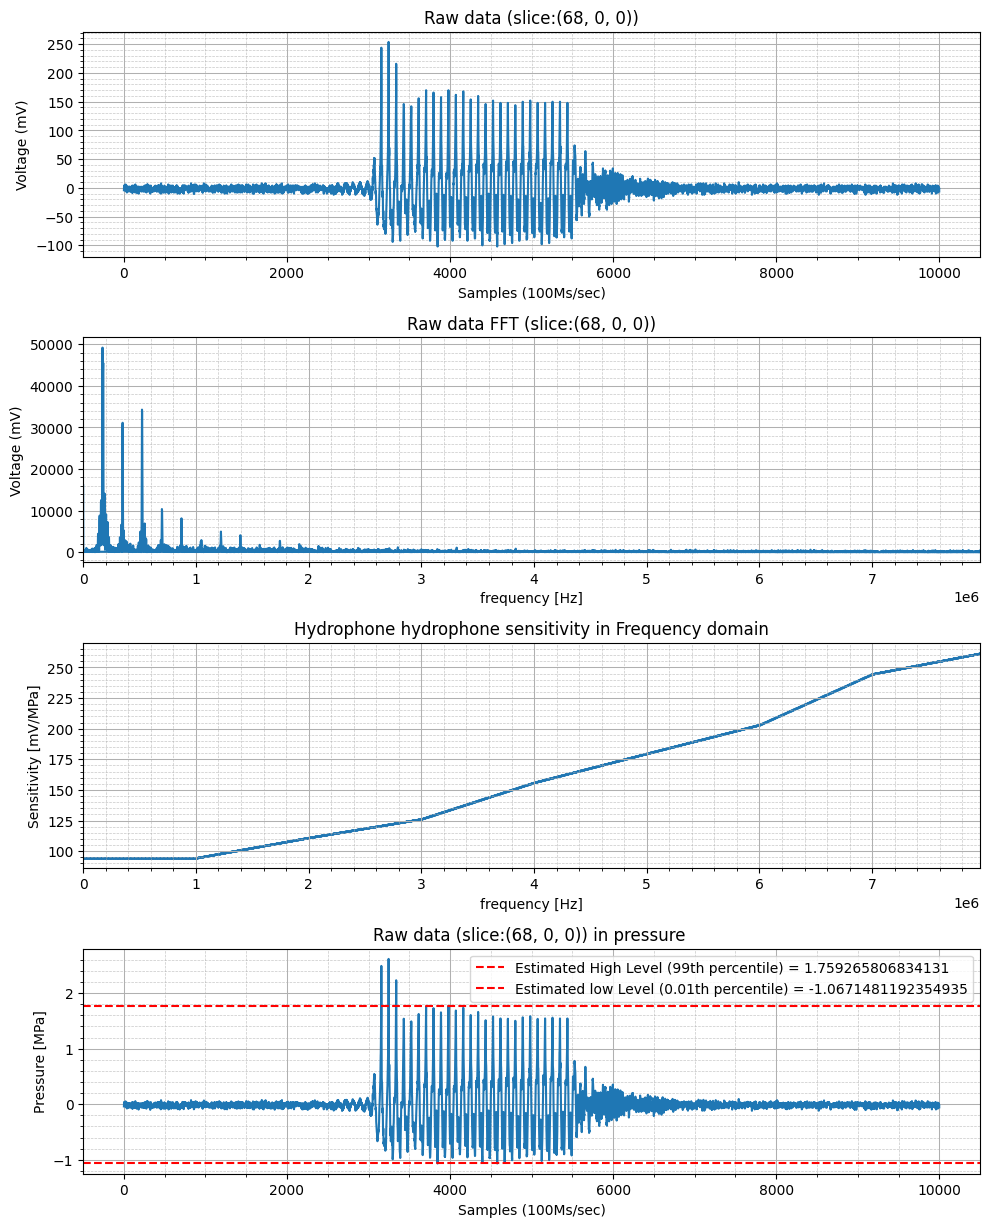

In [7]:
plt.figure(figsize=(10, 15))
plt.subplot(5, 1, 1)
plt.plot(data[slice[0]][slice[1]][slice[2]][:])
plt.title(f"Raw data (slice:{slice})")
plt.xlabel("Samples (100Ms/sec)")
plt.ylabel("Voltage (mV)")
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', linewidth=0.75)  # Thicker lines for major grid
plt.grid(True, which='minor', linestyle='--', linewidth=0.5, alpha=0.7)  # Thinner dashed lines

plt.subplot(5, 1, 2)
plt.plot(freq, np.abs(data_raw_fft[slice[0]][slice[1]][slice[2]][:]) )
plt.minorticks_on()
plt.title(f"Raw data FFT (slice:{slice})")
plt.grid(True, which='major', linestyle='-', linewidth=0.75)  # Thicker lines for major grid
plt.grid(True, which='minor', linestyle='--', linewidth=0.5, alpha=0.7)  # Thinner dashed lines
plt.xlabel("frequency [Hz]")
plt.ylabel("Voltage (mV)")
plt.xlim([0, max(freq)])

plt.subplot(5, 1, 3)
plt.scatter(freq, hydrophone_sensitivity, s=0.1)
plt.minorticks_on()
plt.title(f"Hydrophone hydrophone sensitivity in Frequency domain")
plt.grid(True, which='major', linestyle='-', linewidth=0.75)  # Thicker lines for major grid
plt.grid(True, which='minor', linestyle='--', linewidth=0.5, alpha=0.7)  # Thinner dashed lines
plt.xlabel("frequency [Hz]")
plt.ylabel("Sensitivity [mV/MPa]")
plt.xlim([0, max(freq)])

plt.subplot(5, 1, 4)
plt.plot(data_pressure[slice[0]][slice[1]][slice[2]][:])
plt.minorticks_on()
plt.title(f"Raw data (slice:{slice}) in pressure ")
plt.axhline(pressure_max[slice[0]][slice[1]][slice[2]], color='r', linestyle='--', label=f"Estimated High Level (99th percentile) = {pressure_max[slice[0]][slice[1]][slice[2]]}")
plt.axhline(pressure_min[slice[0]][slice[1]][slice[2]], color='r', linestyle='--', label=f"Estimated low Level (0.01th percentile) = {pressure_min[slice[0]][slice[1]][slice[2]]}")
plt.grid(True, which='major', linestyle='-', linewidth=0.75)  # Thicker lines for major grid
plt.grid(True, which='minor', linestyle='--', linewidth=0.5, alpha=0.7)  # Thinner dashed lines
plt.legend()
plt.xlabel("Samples (100Ms/sec)")
plt.ylabel("Pressure [MPa]")


plt.tight_layout()
plt.show()


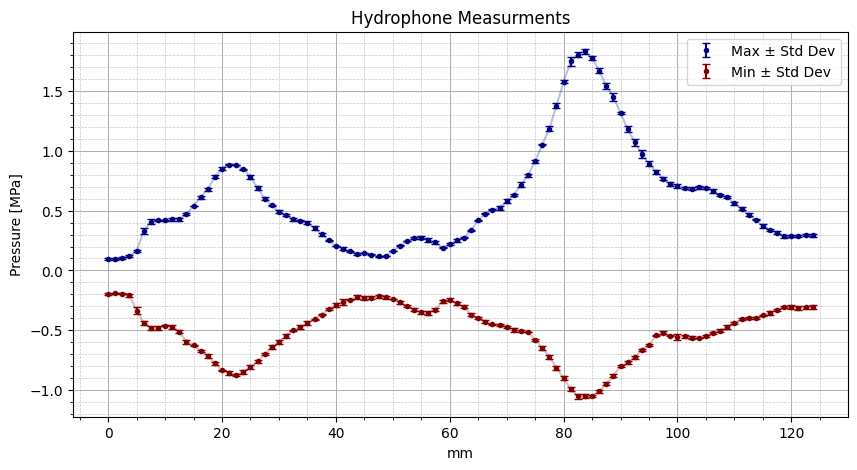

In [8]:
mean_series_max = np.mean(pressure_max, axis=2).squeeze() 
mean_series_min = np.mean(pressure_min, axis=2).squeeze()  
std_series_max = np.std(pressure_max, axis=2).squeeze()   
std_series_min = np.std(pressure_min, axis=2).squeeze()  

# Generate x values
x_values = np.arange(num_of_samples)*steps_per_sample/steps_per_mm

# Plot the series with error bars|
plt.figure(figsize=(10, 5))
plt.errorbar(x_values, mean_series_max, yerr=std_series_max, fmt='.', capsize=3, label='Max ± Std Dev', color='navy')
plt.plot(x_values, mean_series_max, color='navy', alpha=0.25)
plt.errorbar(x_values, mean_series_min, yerr=std_series_min, fmt='.', capsize=3, label='Min ± Std Dev', color='maroon')
plt.plot(x_values, mean_series_min, color='maroon', alpha=0.25)
plt.xlabel("mm")
plt.ylabel("Pressure [MPa]")
plt.title("Hydrophone Measurments")
plt.legend()
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', linewidth=0.75)  # Thicker lines for major grid
plt.grid(True, which='minor', linestyle='--', linewidth=0.5, alpha=0.7)  # Thinner dashed lines for minor grid
plt.show()

In [9]:
print(f"{np.argmax(mean_series_max)} {mean_series_max[np.argmax(mean_series_max)]:.2f}")
print(f"Max pessure was found at: {np.argmax(mean_series_max)*steps_per_sample} steps")

67 1.83
Max pessure was found at: 16750 steps
